In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("./..")

In [479]:
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import tensorflow as tf
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from smallnorb.smallnorb import SmallNORB
from smallnorb.jitter import ColorJitter

In [6]:
ds_train = SmallNORB(root='data/SmallNORB',train=True, download=True,  mode="nopil")

In [24]:
ds_train[0:1][0].size()

torch.Size([1, 2, 96, 96])

In [83]:
img_torch = ds_train[:][0]

In [84]:
img_numpy = img_torch.numpy()

In [85]:
img_numpy.shape

(24300, 2, 96, 96)

In [86]:
print(img_torch.max())
print(img_torch.min())
print(img_torch.mean())
print(img_numpy.max())
print(img_numpy.min())
print(img_numpy.mean())

tensor(252.)
tensor(0.)
tensor(192.4203)
252.0
0.0
192.41997


In [87]:
print(img_torch[...,0,:,:].mean())
print(img_torch[...,0,:,:].std())
print(img_torch[...,1,:,:].mean())
print(img_torch[...,1,:,:].std())

tensor(191.7811)
tensor(45.2232)
tensor(193.0594)
tensor(44.2558)


In [73]:
transform_train = T.Compose([
    T.Normalize(mean=[191.7811,193.0594],std=[45.2232, 44.2558]),
    #T.Normalize(mean=[127.5, 127.5],std=[127.5, 127.5]),
    #T.Resize(64),
    #T.RandomCrop(48),
    #ColorJitter(brightness= [0.,2.], contrast=[0.5,1.5], saturation=0, hue=0),
])
transform_valid = T.Compose([
    #T.Normalize(mean=[191.0684,192.0952],std=[45.4354, 44.3388]),
    T.Normalize(mean=[127.5, 127.5],std=[127.5, 127.5]),
    T.Resize(64),
    T.CenterCrop(48),
])  

In [99]:
#Transform used in torch
transform_train = T.Compose([T.Normalize(mean=[191.7811,193.0594],std=[45.2232, 44.2558])])

img_torch_trans = transform_train(img_torch)
print(img_torch_trans.max())
print(img_torch_trans.min())
print(img_torch_trans.mean())

tensor(-4.2113)
tensor(-4.4609)
tensor(-4.3016)


In [100]:
#orig standadizer
def standardize(x):
    x[...,0] = (x[...,0] - x[...,0].mean()) / x[...,0].std()
    x[...,1] = (x[...,1] - x[...,1].mean()) / x[...,1].std()
    return x

In [101]:
#orig standadizer shape of torch tensor
def standardizer(x):
    x[...,0,:,:] = (x[...,0,:,:] - x[...,0,:,:].mean()) / x[...,0,:,:].std()
    x[...,1,:,:] = (x[...,1,:,:] - x[...,1,:,:].mean()) / x[...,1,:,:].std()
    return x

In [91]:
img_numpy_std_ten = standardizer(img_numpy)

In [92]:
print(img_numpy_std_ten.max())
print(img_numpy_std_ten.min())
print(img_numpy_std_ten.mean())

1.3318003
-4.362371
-6.511206e-06


In [96]:
#reshape array to tensprflow
img_numpy_shape_tf = np.einsum('...ijk -> ...jki', img_numpy)
img_numpy_shape_tf.shape

(24300, 96, 96, 2)

In [98]:
img_numpy_std_tf = standardize(img_numpy_shape_tf)
print(img_numpy_std_tf.max())
print(img_numpy_std_tf.min())
print(img_numpy_std_tf.mean())

1.3318176
-4.362355
-3.6705778e-09


#### Rescaling

In [104]:
def rescale(x):
    with tf.device("/cpu:0"):
        x = tf.image.resize(x , [64, 64])
    return x

In [105]:
#rescaling
img_numpy_res_tf = rescale(img_numpy_std_tf)

In [111]:
print(img_numpy_res_tf.shape)
print(img_numpy_res_tf.numpy().max())
print(img_numpy_res_tf.numpy().min())
print(img_numpy_res_tf.numpy().mean())

(24300, 64, 64, 2)
1.3318176
-4.3270493
1.3429319e-05


In [124]:
img_torch = ds_train[:][0]
#Transform used in torch
transform_train = T.Compose([
    T.Normalize(mean=[191.7811,193.0594],std=[45.2232, 44.2558]),
    T.Resize([64,64]),
    #T.RandomCrop(48),
    #ColorJitter(brightness= [0.,2.], contrast=[0.5,1.5], saturation=0, hue=0),
])

print(img_torch.size())
print(img_torch.max())
print(img_torch.min())
print(img_torch.mean())

img_torch_trans = transform_train(img_torch)
print(img_torch_trans.size())
print(img_torch_trans.max())
print(img_torch_trans.min())
print(img_torch_trans.mean())

torch.Size([24300, 2, 96, 96])
tensor(252.)
tensor(0.)
tensor(192.4203)
torch.Size([24300, 2, 64, 64])
tensor(1.3318)
tensor(-4.3270)
tensor(1.5546e-05)


### random patches

In [227]:
tf.random.set_seed(0)
def random_patches(x):
    #return tf.image.random_crop(x, [48, 48, 2])
    return tf.image.central_crop(x, 0.75)

In [228]:
#patches
tf.random.set_seed(0)
img_numpy_pat_tf = random_patches(img_numpy_res_tf[0])

print(img_numpy_pat_tf.shape)
print(img_numpy_pat_tf.numpy().max())
print(img_numpy_pat_tf.numpy().min())
print(img_numpy_pat_tf.numpy().mean())

(48, 48, 2)
-0.2577501
-2.912633
-0.65179455


(48, 48, 2)
-0.2577501
-2.912633
-0.6553947


In [156]:
img_torch = ds_train[:][0]
torch.manual_seed(0)
#Transform used in torch
transform_train = T.Compose([
    T.Normalize(mean=[191.7811,193.0594],std=[45.2232, 44.2558]),
    T.Resize([64,64]),
    #T.RandomCrop(48),
    #ColorJitter(brightness= [0.,2.], contrast=[0.5,1.5], saturation=0, hue=0),
])

print("#" * 50)
print(img_torch.size())
print(img_torch.max())
print(img_torch.min())
print(img_torch.mean())

img_torch_trans = transform_train(img_torch)
print("#" * 50)
print(img_torch_trans.size())
print(img_torch_trans.max())
print(img_torch_trans.min())
print(img_torch_trans.mean())



##################################################
torch.Size([24300, 2, 96, 96])
tensor(252.)
tensor(0.)
tensor(192.4203)
##################################################
torch.Size([24300, 2, 64, 64])
tensor(1.3318)
tensor(-4.3270)
tensor(1.5546e-05)


In [218]:
torch.manual_seed(0)
img_torch_pat = T.RandomCrop([48,48])(img_torch_trans[0])
#img_torch_pat = T.CenterCrop([48,48])(img_torch_trans[0])
print("#" * 50)
print(img_torch_pat.size())
print(img_torch_pat.max())
print(img_torch_pat.min())
print(img_torch_pat.mean())

##################################################
torch.Size([2, 48, 48])
tensor(-0.2577)
tensor(-2.9126)
tensor(-0.6531)


In [224]:

a = img_numpy_pat_tf.numpy().max()  - img_torch_pat.numpy().max()
b = img_numpy_pat_tf.numpy().min()  - img_torch_pat.numpy().min()
c = img_numpy_pat_tf.numpy().mean() - img_torch_pat.numpy().mean()
d = np.einsum("jik -> kji", img_numpy_pat_tf.numpy()) - img_torch_pat.numpy()


print(a)
print(b)
print(c)

-4.142523e-06
4.7683716e-07
-0.0022916794


In [220]:
tf.random.set_seed(0)
print(tf.random.uniform([1]))
torch.manual_seed(0)
print(torch.rand([1]))

tf.Tensor([0.29197514], shape=(1,), dtype=float32)
tensor([0.4963])


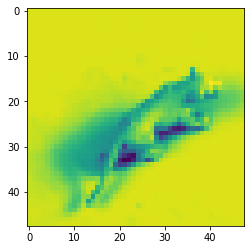

In [221]:
imshow(img_torch_pat.numpy()[0])

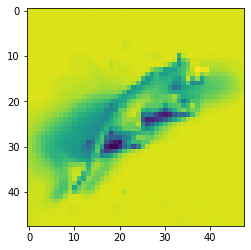

In [222]:
imshow(np.einsum("jik -> kji", img_numpy_pat_tf.numpy())[0])

4.539978


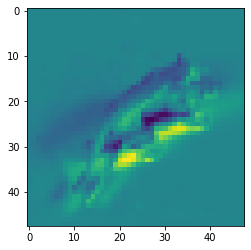

In [223]:
print(d[0].max()-d[0].min())
imshow(d[0])

###
ohne random besteht kein unterschied zwischen crop funcs. 
mit random wird nicht der selbe seed genutzt.
aber max und min nahezu gleich. sollte passen

### Random brigthness

In [342]:
img_torch = ds_train[:][0]
#Transform used in torch
transform_train = T.Compose([
    T.Normalize(mean=[191.7811,193.0594],std=[45.2232, 44.2558]),
    T.Resize([64,64]),
    #T.RandomCrop(48),
    #ColorJitter(brightness= [0.,2.], contrast=[0.5,1.5], saturation=0, hue=0),
])

print("#" * 50)
print(img_torch.size())
print(img_torch.max())
print(img_torch.min())
print(img_torch.mean())

img_torch_trans = transform_train(img_torch)
print("#" * 50)
print(img_torch_trans.size())
print(img_torch_trans.max())
print(img_torch_trans.min())
print(img_torch_trans.mean())


#img_torch_pat = T.RandomCrop([48,48])(img_torch_trans[0])
img_torch_pat = T.CenterCrop([48,48])(img_torch_trans[0])
print("#" * 50)
print(img_torch_pat.size())
print(img_torch_pat.max())
print(img_torch_pat.min())
print(img_torch_pat.mean())

##################################################
torch.Size([24300, 2, 96, 96])
tensor(252.)
tensor(0.)
tensor(192.4203)
##################################################
torch.Size([24300, 2, 64, 64])
tensor(1.3318)
tensor(-4.3270)
tensor(1.5546e-05)
##################################################
torch.Size([2, 48, 48])
tensor(-0.2577)
tensor(-2.9126)
tensor(-0.6518)


In [339]:
def random_brightness(x):
    tf.random.set_seed(0)
    #return tf.image.random_brightness(x, max_delta=2.0)
    return tf.image.adjust_brightness(x, 2.0)

In [340]:
img_numpy_bri_tf = random_brightness(img_numpy_pat_tf)

print(img_numpy_bri_tf.shape)
print(img_numpy_bri_tf.numpy().max())
print(img_numpy_bri_tf.numpy().min())
print(img_numpy_bri_tf.numpy().mean())

(48, 48, 2)
1.74225
-0.91263294
1.3482054


In [333]:
#torch.manual_seed(0)
#img_torch_bri = T.ColorJitter(brightness= [-0.2,0.2])(img_torch_pat[0])#, contrast=[0.5,1.5], saturation=0, hue=0),
img_torch_bri = T.functional.adjust_brightness(img_torch_pat[0]-img_torch_pat[0].min(),brightness_factor=2)
#-img_torch_pat[0].min()
print(img_torch_bri.size())
print(img_torch_bri.max())
print(img_torch_bri.min())
print(img_torch_bri.mean())

torch.Size([48, 48])
tensor(1.)
tensor(0.)
tensor(0.9969)


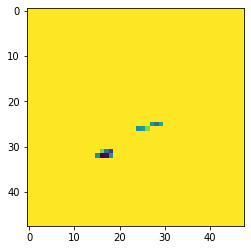

In [334]:
imshow(img_torch_bri.numpy())

tensor([0.7576]) tensor([1.0305])
torch.Size([48, 48])
tensor(-0.2656)
tensor(-3.0015)
tensor(-0.6371)


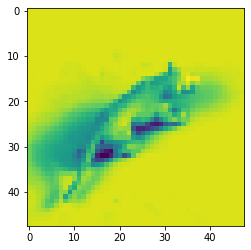

In [353]:
torch.manual_seed(1)
#img_torch_bri = T.ColorJitter(brightness= [-0.2,0.2])(img_torch_pat[0])#, contrast=[0.5,1.5], saturation=0, hue=0),
#img_torch_bri = T.functional.adjust_brightness(img_torch_pat[0]-img_torch_pat[0].min(),brightness_factor=2)
#-img_torch_pat[0].min()
p = torch.rand([1])
pp = ((p-0.5)*2) *2
print(p, pp)
img_torch_bri = img_torch_pat[0] * pp
print(img_torch_bri.size())
print(img_torch_bri.max())
print(img_torch_bri.min())
print(img_torch_bri.mean())
imshow(img_torch_bri.numpy())

In [434]:
img_torch = ds_train[:][0]
#Transform used in torch
img_torch = img_torch[0,:1]
print(img_torch.size())

torch.Size([1, 96, 96])


##################################################
torch.Size([1, 96, 96])
tensor(183.)
tensor(54.)
tensor(167.8820)
##################################################
torch.Size([1, 48, 48])
tensor(1.3979)
tensor(-2.7559)
tensor(1.1832)


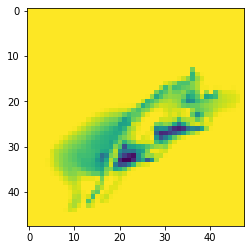

In [475]:
transform_train = T.Compose([
    T.Lambda(lambda x: x/255),
    
    ColorJitter(brightness=1., contrast=[0.5,1.5], saturation=0, hue=0),
    T.Lambda(lambda x: x*255),
    T.Normalize(mean=[191.7811],std=[45.2232]),
    T.Resize([64]),
    T.RandomCrop(48),
])

print("#" * 50)
print(img_torch.size())
print(img_torch.max())
print(img_torch.min())
print(img_torch.mean())

img_torch_trans = transform_train(img_torch)
print("#" * 50)
print(img_torch_trans.size())
print(img_torch_trans.max())
print(img_torch_trans.min())
print(img_torch_trans.mean())

imshow(img_torch_trans[0,:,:].numpy())

In [482]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F

In [538]:
transform_train = T.Compose([
    #T.Lambda(lambda x: x/255.),
    #ColorJitter(brightness=1., contrast=[0.5,1.5], saturation=0, hue=0),
    #T.Lambda(lambda x: x*255.),
    T.Normalize(mean=[191.7811/255,193.0594/255],std=[45.2232/255, 44.2558/255]),
    T.Resize([64]),
    T.RandomCrop(48),
])


train = SmallNORB(root='data/SmallNORB',train=True,transform=None, download=True,  mode="stereo")

print(train[0][:2])

dl_train = torch.utils.data.DataLoader(train, 
                                       batch_size=16, 
                                       shuffle=True, 
                                       num_workers=4)

(<PIL.Image.Image image mode=L size=96x96 at 0x1ED01604460>, <PIL.Image.Image image mode=L size=96x96 at 0x1ED01604430>)


In [533]:
# plot train imgs
x, y, z = next(iter(dl_train))

x[:64,:1,:,:].size()
x[:64,1:2,:,:].size()
p = x[0,:1,:,:]
print(p.size())
print(p.max())
print(p.min())
print(p.mean())

PicklingError: Can't pickle <class 'smallnorb.smallnorb.SmallNORB'>: it's not the same object as smallnorb.smallnorb.SmallNORB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


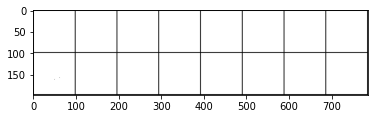

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


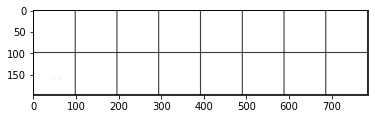

In [520]:
# plot train imgs
x, y, z = next(iter(dl_train))

# stereo channel 1
img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# stereo channel 2
img = torchvision.utils.make_grid(x[:64,1:2,:,:], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

In [ ]:
>>> arr = np.random.uniform(size=(3,256,256))*255
>>> arr = np.ascontiguousarray(arr.transpose(1,2,0))
>>> img = Image.fromarray(arr, 'RGB')
>>> img.save('out.png')


https://coderedirect.com/questions/231074/how-to-save-a-3-channel-numpy-array-as-image